# ADA Project Milestone P2 Deliverable

## <span style="color: green;">Import libraries and set paths </span>

For data cleaning and EDA, import the following libraries:

In [2]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode as ud
from collections import Counter
from datetime import datetime
%matplotlib inline

If you further try sentiment analysis, import the following libraries:

In [2]:
import torch
from tqdm import tqdm
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from lime.lime_text import LimeTextExplainer

Set the global variables for the paths to the data folder.

In [ ]:
# add your data folder into the 'code' folder, make sure it is in the .gitignore file

CODE_DIR = os.getcwd()
DATA_DIR = os.path.join(CODE_DIR, 'data')

print('your data directory:')
DATA_DIR

your data directory:


'c:\\Users\\fulci\\git\\ada_23\\ada-2023-project-adarescueteam\\code\\data'

In [ ]:
# set path for BeerAdvocate data
DATA_BeerAdvocate = os.path.join(DATA_DIR, "BeerAdvocate.tar")

# set path for RateBeer data
DATA_RateBeer = os.path.join(DATA_DIR, "RateBeer.tar")

# set path for MatchedBeer data
DATA_MatchedBeers = os.path.join(DATA_DIR, "matched_beer_data.tar")

## <span style="color: green;">Define functions to load huge txt files</span>

### Convert the time for the users dataset

In [5]:
# convert the joined
def convert_timestamp(timestamp):
    try:
        timestamp = float(timestamp)
        return datetime.fromtimestamp(timestamp)
    except (ValueError, TypeError):
        return None

<span style="color: red;">One can choose skipping the implementation of 'Read ratings' and 'Read reviews' if you downloaded the .csv data</span> ([download here preprocessed .txt to .csv data](https://drive.google.com/drive/folders/1ZhaUtzQaGtIEi6PmHZ7uXhoo7sC1byAT?usp=sharing))

Please place the .csv files in their corresponding folders.

In [127]:
# change the boolean to false if you did not download the data
CSV_DOWNLOAD = True

### Read ratings

In [104]:
# read in the ratings
def read_ratings_txt(folder, file_name):
    data = []
    counter = 0

    with open(os.path.join(folder, file_name), 'rb') as file:
        rating_data = {}
        for line in file:
            line = line.strip()
            if line.startswith(b'beer_name:'):
                # check if dictionary is not empty
                if rating_data:
                    data.append(rating_data)
                rating_data = {'beer_name': line.split(b'beer_name:')[1].decode('utf-8')}
            elif line.startswith(b'beer_id:'):
                rating_data['beer_id'] = line.split(b'beer_id:')[1].decode('utf-8')
            elif line.startswith(b'brewery_name:'):
                rating_data['brewery_name'] = line.split(b'brewery_name:')[1].decode('utf-8')
            elif line.startswith(b'brewery_id:'):
                rating_data['brewery_id'] = line.split(b'brewery_id:')[1].decode('utf-8')
            elif line.startswith(b'style:'):
                rating_data['style'] = line.split(b'style:')[1].decode('utf-8')
            elif line.startswith(b'abv:'):
                rating_data['abv'] = line.split(b'abv:')[1].decode('utf-8')
            elif line.startswith(b'date:'):
                timestamp = float(line.split(b'date:')[1].decode('utf-8'))
                rating_data['date'] = datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
            elif line.startswith(b'user_name:'):
                rating_data['user_name'] = line.split(b'user_name:')[1].decode('utf-8')
            elif line.startswith(b'user_id:'):
                rating_data['user_id'] = line.split(b'user_id:')[1].decode('utf-8')
            elif line.startswith(b'appearance:'):
                rating_data['appearance'] = line.split(b'appearance:')[1].decode('utf-8')
            elif line.startswith(b'aroma:'):
                rating_data['aroma'] = line.split(b'aroma:')[1].decode('utf-8')
            elif line.startswith(b'palate:'):
                rating_data['palate'] = line.split(b'palate:')[1].decode('utf-8')
            elif line.startswith(b'taste:'):
                rating_data['taste'] = line.split(b'taste:')[1].decode('utf-8')
            elif line.startswith(b'overall:'):
                rating_data['overall'] = line.split(b'overall:')[1].decode('utf-8')
            elif line.startswith(b'rating:'):
                rating_data['rating'] = line.split(b'rating:')[1].decode('utf-8')
            elif line.startswith(b'text:'):
                rating_data['text'] = line.split(b'text:')[1].decode('utf-8')
            elif line.startswith(b'review:'):
                rating_data['review'] = line.split(b'review:')[1].decode('utf-8')

            #counter += 1

            #if counter == 1000000:  # limit amount of lines to read in (17lines in the data are 1 row)
            #    break

    if rating_data:
        data.append(rating_data)

    ratings = pd.DataFrame(data)
    return ratings

### Read reviews

In [105]:
# read in the reviews
def read_reviews_txt(folder, file_name):
    data = []
    counter = 0

    with open(os.path.join(folder, file_name), 'rb') as file:
        review_data = {}
        for line in file:
            line = line.strip()
            if line.startswith(b'beer_name:'):
                # check if dictionary is not empty
                if review_data:
                    data.append(review_data)
                review_data = {'beer_name': line.split(b'beer_name:')[1].decode('utf-8')}
            elif line.startswith(b'beer_id:'):
                review_data['beer_id'] = line.split(b'beer_id:')[1].decode('utf-8')
            elif line.startswith(b'brewery_name:'):
                review_data['brewery_name'] = line.split(b'brewery_name:')[1].decode('utf-8')
            elif line.startswith(b'brewery_id:'):
                review_data['brewery_id'] = line.split(b'brewery_id:')[1].decode('utf-8')
            elif line.startswith(b'style:'):
                review_data['style'] = line.split(b'style:')[1].decode('utf-8')
            elif line.startswith(b'abv:'):
                review_data['abv'] = line.split(b'abv:')[1].decode('utf-8')
            elif line.startswith(b'date:'):
                timestamp = float(line.split(b'date:')[1].decode('utf-8'))
                review_data['date'] = datetime.utcfromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S')
            elif line.startswith(b'user_name:'):
                review_data['user_name'] = line.split(b'user_name:')[1].decode('utf-8')
            elif line.startswith(b'user_id:'):
                review_data['user_id'] = line.split(b'user_id:')[1].decode('utf-8')
            elif line.startswith(b'appearance:'):
                review_data['appearance'] = line.split(b'appearance:')[1].decode('utf-8')
            elif line.startswith(b'aroma:'):
                review_data['aroma'] = line.split(b'aroma:')[1].decode('utf-8')
            elif line.startswith(b'palate:'):
                review_data['palate'] = line.split(b'palate:')[1].decode('utf-8')
            elif line.startswith(b'taste:'):
                review_data['taste'] = line.split(b'taste:')[1].decode('utf-8')
            elif line.startswith(b'overall:'):
                review_data['overall'] = line.split(b'overall:')[1].decode('utf-8')
            elif line.startswith(b'rating:'):
                review_data['rating'] = line.split(b'rating:')[1].decode('utf-8')
            elif line.startswith(b'text:'):
                review_data['text'] = line.split(b'text:')[1].decode('utf-8')


            #counter += 1

            #if counter == 10001:  # limit amount of lines to read in
            #    break

    if review_data:
        data.append(review_data)

    reviews = pd.DataFrame(data)
    return reviews

# <span style="color: darkgreen;">LOAD FILES</span>

### <span style="color: green;">BeerAdvocate (BA) Dataset</span>

### beers.csv

In [113]:
# read in the beers.csv file as a DataFrame
BA_beers = pd.read_csv(os.path.join(DATA_BeerAdvocate, "beers.csv"))
print(BA_beers.shape)
BA_beers.head()

(280823, 15)


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,166064,Nashe Moskovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.7,NaN,NaN,0,NaN
1,166065,Nashe Pivovskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,3.8,NaN,NaN,0,NaN
2,166066,Nashe Shakhterskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.8,NaN,NaN,0,NaN
3,166067,Nashe Zhigulevskoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.0,NaN,NaN,0,NaN
4,166063,Zhivoe,39912,Abdysh-Ata (Абдыш Ата),Euro Pale Lager,0,0,NaN,NaN,NaN,4.5,NaN,NaN,0,NaN


### breweries.csv

In [114]:
BA_breweries = pd.read_csv(os.path.join(DATA_BeerAdvocate, "breweries.csv"))
print(BA_breweries.shape)
BA_breweries.head()

(16758, 4)


,id,location,name,nbr_beers
0,39912,Kyrgyzstan,Abdysh-Ata (Абдыш Ата),5
1,39913,Kyrgyzstan,Arpa (АРПА),1
2,39914,Kyrgyzstan,Bear Beer,4
3,39915,Kyrgyzstan,Blonder Pub,4
4,39916,Kyrgyzstan,Kellers Bier,2


### users.csv

In [142]:
BA_users = pd.read_csv(os.path.join(DATA_BeerAdvocate, "users.csv"), 
                       converters={"joined": convert_timestamp}
                       )
print(BA_users.shape)
BA_users.head()

(153704, 6)


,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
0,7820,465,nmann08.184925,nmann08,2008-01-07 12:00:00,"United States, Washington"
1,2521,2504,stjamesgate.163714,StJamesGate,2007-10-08 12:00:00,"United States, New York"
2,1797,1143,mdagnew.19527,mdagnew,2005-05-18 12:00:00,Northern Ireland
3,31,31,helloloser12345.10867,helloloser12345,2004-11-25 12:00:00,Northern Ireland
4,604,604,cypressbob.3708,cypressbob,2003-11-20 12:00:00,Northern Ireland


### ratings.txt

In [106]:
BA_ratings = pd.DataFrame()
if not CSV_DOWNLOAD:
    # read in the .txt
    BA_ratings = read_ratings_txt(DATA_BeerAdvocate, "ratings.txt")
    print(BA_ratings.shape)
    BA_ratings.head()


    #BA_ratings['text'] = BA_ratings['text'].apply(lambda x: ud.unidecode(x))       # doesnt work because there is floats, like prices in the reviews

    # fix the encoding issues manually
    BA_ratings['text'] = (BA_ratings['text'].str.replace('Ã³', 'ó')     # replacing the unicodes manually
                    .str.replace('Ã¡', 'á')
                    .str.replace('Ã©', 'é')
                    .str.replace('Å‚', 'ł')
                    .str.replace("Ã¢Â€Â™", "’")
                    .str.replace('Ã±', 'ñ')
                    .str.replace('Ã\xad','í')
                    .str.replace('Ã¶', 'ö')
                    .str.replace("Ã¤", "ä")
                    .str.replace("Ã¥", "å")
                    .str.replace("Ã¶", "ö")
                    .str.replace("Ã¸", "ø")
                    .str.replace("Ã¦", "æ")
                    .str.replace('Ã\x9f', 'ß')
                    .str.replace("Ã¨", "è")
                    .str.replace('Â£', '£')
                    .str.replace('â\x80\x93', '-')
                    .str.replace("Ã´", "ô")
                    .str.replace("â\x80\x99", "’")
                    .str.replace("Ã¼", "ü")
                    .str.replace("Â\xa0", "")
                    .str.replace("\xa0", " ")
                    .str.replace("[email\xa0protected]/*  */", "")
                    .str.replace('Ã®', 'î')
                    .str.replace('Ãª', 'ê')
                    .str.replace('Ã»', 'û')
                    .str.replace('Ã\x87', 'Ç')
                    .str.replace('Ã§', 'ç')
                    .str.replace('Ã', 'à')
                    .str.replace('Ã¢', 'â')
                    .str.replace('Ã¯', 'ï'))   


    # create a csv from BA_ratings
    BA_ratings.to_csv(os.path.join(DATA_BeerAdvocate, "BA_ratings.csv"), index=False, encoding='utf-8')

(8393032, 17)


another idea: COULD have the chunk below in  separate function,

also just keep the  .str.replace("[email\xa0protected]/*  */", "") part

In [128]:
if CSV_DOWNLOAD:
    # read in new BA_ratings.csv
    BA_ratings = pd.read_csv(os.path.join(DATA_BeerAdvocate, "BA_ratings.csv"), header=0, low_memory=False ,encoding='utf-8')
    print(BA_ratings.shape)

(8393032, 17)


In [139]:
# testing of the text format, can skip
for i in range(4999, 5000):
    display(BA_ratings['text'][i])

' A: snifter. pours a dark rich brown, practically black. a light tan head on top and a low retention rate. light lacing.S: coconut, cherries, vanilla and roasted malts, chocolate and caramel. light coffee hints. huge peaty whiskey aromas. T: tastes like heaven. outstanding old ale, best yet IMO. coconut, vanilla, cherries, bourbon/scotch flavors. some light chocolate and toffee. hints of coffee. M: medium body, low carbonation. huge roasted and barrel aged palate. so intense.D: i could literally drink maybe 3 of these, but a dozen is my goal....absolutely delicious. worth getting...you better believe it!'

In [26]:
BA_ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review
0,Régab,142544,Societe des Brasseries du Gabon (SOBRAGA),37262,Euro Pale Lager,4.5,2015-08-20 10:00:00,nmann08,nmann08.184925,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with...",True
1,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2009-02-20 11:00:00,StJamesGate,stjamesgate.163714,3.0,3.5,3.5,4.0,3.5,3.67,Pours pale copper with a thin head that quick...,True
2,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2006-03-13 11:00:00,mdagnew,mdagnew.19527,4.0,3.5,3.5,4.0,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim....",True
3,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2004-12-01 11:00:00,helloloser12345,helloloser12345.10867,4.0,3.5,4.0,4.0,4.5,3.98,Serving: 500ml brown bottlePour: Good head wi...,True
4,Barelegs Brew,19590,Strangford Lough Brewing Company Ltd,10093,English Pale Ale,4.5,2004-08-30 10:00:00,cypressbob,cypressbob.3708,4.0,4.0,4.0,4.0,4.0,4.00,"500ml bottlePours with a light, slightly hazy...",True


### reviews.txt

In [107]:
BA_reviews = pd.DataFrame()
if not CSV_DOWNLOAD:
    # read the .txt file
    BA_reviews = read_reviews_txt(DATA_BeerAdvocate, "reviews.txt")
    BA_reviews.head(), BA_reviews.shape

    # fix the encoding issues manually
    BA_reviews['text'] = (BA_reviews['text'].str.replace('Ã³', 'ó')
                        .str.replace('Ã¡', 'á')
                        .str.replace('Ã©', 'é')
                        .str.replace('Å‚', 'ł')
                        .str.replace("Ã¢Â€Â™", "’")
                        .str.replace('Ã±', 'ñ')
                        .str.replace('Ã\xad','í')
                        .str.replace('Ã¶', 'ö')
                        .str.replace("Ã¤", "ä")
                        .str.replace("Ã¥", "å")
                        .str.replace("Ã¶", "ö")
                        .str.replace("Ã¸", "ø")
                        .str.replace("Ã¦", "æ")
                        .str.replace('Ã\x9f', 'ß')
                        .str.replace("Ã¨", "è")
                        .str.replace('Â£', '£')
                        .str.replace('â\x80\x93', '-')
                        .str.replace("Ã´", "ô")
                        .str.replace("â\x80\x99", "’")
                        .str.replace("Ã¼", "ü")
                        .str.replace("Â\xa0", "")
                        .str.replace("\xa0", " ")
                        .str.replace("[email\xa0protected]/*  */", "")
                        .str.replace('Ã®', 'î')
                        .str.replace('Ãª', 'ê')
                        .str.replace('Ã»', 'û')
                        .str.replace('Ã\x87', 'Ç')
                        .str.replace('Ã§', 'ç')
                        .str.replace('Ã', 'à')
                        .str.replace('Ã¢', 'â')
                        .str.replace('Ã¯', 'ï'))    

    # write the csv file
    BA_reviews.to_csv(os.path.join(DATA_BeerAdvocate, "BA_reviews.csv"), index=False, encoding='utf-8')

In [129]:
if CSV_DOWNLOAD:
    # read back in the csv file
    BA_reviews = pd.read_csv(os.path.join(DATA_BeerAdvocate, "BA_reviews.csv"), header=0, low_memory=False ,encoding='utf-8')
    print(BA_reviews.shape)

(2589586, 16)


## <span style="color: green;">RateBeer (RB) Dataset</span>

### beers.csv

In [116]:
# read in the beers.csv file as a DataFrame
RB_beers = pd.read_csv(os.path.join(DATA_RateBeer, "beers.csv"))
print(RB_beers.shape)
RB_beers.head()

(442081, 14)


,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,overall_score,style_score,avg,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
0,410549,33 Export (Gabon),3198,Sobraga,Pale Lager,1,NaN,NaN,2.72,5.0,2.000000,NaN,0,NaN
1,105273,Castel Beer (Gabon),3198,Sobraga,Pale Lager,10,5.0,58.0,2.18,5.2,1.910000,NaN,0,NaN
2,19445,Régab,3198,Sobraga,Pale Lager,27,1.0,22.0,1.83,4.5,1.811111,NaN,0,NaN
3,155699,Ards Bally Black Stout,13538,Ards Brewing Co.,Stout,6,NaN,NaN,3.18,4.6,3.866667,0.823699,6,3.866667
4,239097,Ards Belfast 366,13538,Ards Brewing Co.,Golden Ale/Blond Ale,1,NaN,NaN,2.79,4.2,3.000000,NaN,0,NaN


### breweries.csv

In [117]:
RB_breweries = pd.read_csv(os.path.join(DATA_RateBeer, "breweries.csv"))
print(RB_breweries.shape)
RB_breweries.head()

(24189, 4)


,id,location,name,nbr_beers
0,3198,Gabon,Sobraga,3
1,13538,Northern Ireland,Ards Brewing Co.,13
2,22304,Northern Ireland,Barrahooley Craft Brewery,4
3,22818,Northern Ireland,Boundary,66
4,24297,Northern Ireland,Brewbot Belfast,3


### users.csv

In [118]:
RB_users = pd.read_csv(os.path.join(DATA_RateBeer, "users.csv"),
                       converters={"joined": convert_timestamp}
                       )
print(RB_users.shape)
RB_users.head()

(70174, 5)


,nbr_ratings,user_id,user_name,joined,location
0,1890,175852,Manslow,2012-05-20 12:00:00,Poland
1,89,442761,MAGICuenca91,2017-01-10 12:00:00,Spain
2,169,288889,Sibarh,2013-11-16 12:00:00,Poland
3,3371,250510,fombe89,2013-03-22 12:00:00,Spain
4,13043,122778,kevnic2008,2011-02-02 12:00:00,Germany


### reviews.txt

In [108]:
RB_reviews = pd.DataFrame()
if not CSV_DOWNLOAD:
    # read in the .txt file
    RB_reviews = read_reviews_txt(DATA_RateBeer, "reviews.txt")
    RB_reviews.head(), RB_reviews.shape

    RB_reviews['text'] = (RB_reviews['text'].str.replace('Ã³', 'ó')
                        .str.replace('Ã¡', 'á')
                        .str.replace('Ã©', 'é')
                        .str.replace('Å‚', 'ł')
                        .str.replace("Ã¢Â€Â™", "’")
                        .str.replace('Ã±', 'ñ')
                        .str.replace('Ã\xad','í')
                        .str.replace('Ã¶', 'ö')
                        .str.replace("Ã¤", "ä")
                        .str.replace("Ã¥", "å")
                        .str.replace("Ã¶", "ö")
                        .str.replace("Ã¸", "ø")
                        .str.replace("Ã¦", "æ")
                        .str.replace('Ã\x9f', 'ß')
                        .str.replace("Ã¨", "è")
                        .str.replace('Â£', '£')
                        .str.replace('â\x80\x93', '-')
                        .str.replace("Ã´", "ô")
                        .str.replace("â\x80\x99", "’")
                        .str.replace("Ã¼", "ü")
                        .str.replace("Â\xa0", "")
                        .str.replace("\xa0", " ")
                        .str.replace("[email\xa0protected]/*  */", "")
                        .str.replace('Ã®', 'î')
                        .str.replace('Ãª', 'ê')
                        .str.replace('Ã»', 'û')
                        .str.replace('Ã\x87', 'Ç')
                        .str.replace('Ã§', 'ç')
                        .str.replace('Ã', 'à')
                        .str.replace('Ã¢', 'â')
                        .str.replace('Ã¯', 'ï'))  

    # write the csv file
    RB_reviews.to_csv(os.path.join(DATA_RateBeer, "RB_reviews.csv"), index=False, encoding='utf-8')

In [130]:
if CSV_DOWNLOAD:
    # read back in the reviews csv file
    RB_reviews = pd.read_csv(os.path.join(DATA_RateBeer, "RB_reviews.csv"), header=0, encoding='utf-8')
    print(RB_reviews.shape)

C:\Users\fulci\AppData\Local\Temp\ipykernel_14568\3930797610.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  RB_reviews = pd.read_csv(os.path.join(DATA_RateBeer, "RB_reviews.csv"), header=0, encoding='utf-8')


(7122074, 16)


In [94]:
RB_reviews.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2,4,2,4,8,2.00,"Puszka 0,33l dzięki Christoph . Kolor jasnozł..."
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761,2,3,2,4,8,1.90,Cerveza pale lager gabonesa. Más floja que la...
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889,3,3,2,3,5,1.60,"Kolor- złoty, klarowny. Piana - drobna, średn..."
3,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510,4,3,1,2,5,1.50,"Botella, de Gabón regalo familiar.31/01/2015C..."
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778,2,4,2,4,7,1.90,Many thanks for this beer to Erzengel. Pours ...


In [ ]:
# testing of the text format, can skip
for i in range(480, 550):
    display(RB_ratings['text'][i])

### ratings.txt <span style="color: red;">(ratings, reviews are equal, can use just ratings)</span>

In [109]:
RB_ratings = pd.DataFrame()
if not CSV_DOWNLOAD:
    # read in the .txt
    RB_ratings = read_ratings_txt(DATA_RateBeer, "ratings.txt") # has no 'review' column
    RB_ratings.head(), RB_ratings.shape

    # fix the encoding issues manually
    RB_ratings['text'] = (RB_ratings['text'].str.replace('Ã³', 'ó')
                        .str.replace('Ã¡', 'á')
                        .str.replace('Ã©', 'é')
                        .str.replace('Å‚', 'ł')
                        .str.replace("Ã¢Â€Â™", "’")
                        .str.replace('Ã±', 'ñ')
                        .str.replace('Ã\xad','í')
                        .str.replace('Ã¶', 'ö')
                        .str.replace("Ã¤", "ä")
                        .str.replace("Ã¥", "å")
                        .str.replace("Ã¶", "ö")
                        .str.replace("Ã¸", "ø")
                        .str.replace("Ã¦", "æ")
                        .str.replace('Ã\x9f', 'ß')
                        .str.replace("Ã¨", "è")
                        .str.replace('Â£', '£')
                        .str.replace('â\x80\x93', '-')
                        .str.replace("Ã´", "ô")
                        .str.replace("â\x80\x99", "’")
                        .str.replace("Ã¼", "ü")
                        .str.replace("Â\xa0", "")
                        .str.replace("\xa0", " ")
                        .str.replace("[email\xa0protected]/*  */", "")
                        .str.replace('Ã®', 'î')
                        .str.replace('Ãª', 'ê')
                        .str.replace('Ã»', 'û')
                        .str.replace('Ã\x87', 'Ç')
                        .str.replace('Ã§', 'ç')
                        .str.replace('Ã', 'à')
                        .str.replace('Ã¢', 'â')
                        .str.replace('Ã¯', 'ï'))    

    # write the csv file
    RB_ratings.to_csv(os.path.join(DATA_RateBeer, "RB_rxatings.csv"), index=False, encoding='utf-8')

In [131]:
# only read in reviews
if CSV_DOWNLOAD:
    # read back in the ratings csv file
    RB_ratings = pd.read_csv(os.path.join(DATA_RateBeer, "RB_ratings.csv"), header=0, low_memory=False ,encoding='utf-8')
    print(RB_ratings.shape)

(7122074, 16)


In [86]:
RB_ratings.head()

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,33 Export (Gabon),410549,Sobraga,3198,Pale Lager,5.0,2016-04-26 10:00:00,Manslow,175852,2,4,2,4,8,2.00,"Puszka 0,33l dzięki Christoph . Kolor jasnozł..."
1,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2017-02-17 11:00:00,MAGICuenca91,442761,2,3,2,4,8,1.90,Cerveza pale lager gabonesa. Más floja que la...
2,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-06-24 10:00:00,Sibarh,288889,3,3,2,3,5,1.60,"Kolor- złoty, klarowny. Piana - drobna, średn..."
3,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2016-01-01 11:00:00,fombe89,250510,4,3,1,2,5,1.50,"Botella, de Gabón regalo familiar.31/01/2015C..."
4,Castel Beer (Gabon),105273,Sobraga,3198,Pale Lager,5.2,2015-10-23 10:00:00,kevnic2008,122778,2,4,2,4,7,1.90,Many thanks for this beer to Erzengel. Pours ...


In [110]:
# testing of the text format, can skip
for i in range(488, 500):
    display(RB_ratings['text'][i])

' Hazed deep golden color with fine white head. Ok mild aroma with some Belgian yeast, fruity and mild citric. Fine body and a soft carbonation. Fine balance between sweetness and acidity. Fruity, yeast and citric flavor. Nice tasty ale.[On tap @ source]'

' On tap at the brewpub. Pours pitch black with no head at all. Aroma is weak roast with traces of liquorice. Taste is flat and boring, moderate sweet unfermented worth comes to mind.Watery thin palate, flat carbonated, hope the next brews will be a lot better than this.'

' #755Tap at the brewery bar. Slightly hazy deep golden to amber body, medium white head. Aroma of cherries, flowers, touch of licorice. Taste is semi-dry, slightly bitter. Flowers, citrusy peel. Medium to full body, moderately carbonated.Good one.'

' Draught at Brewbot, Belfast. Cloudy, pale amber colored. AROMA- tropical fruit, apricots, strawberries. FLAVOR- neutral, lightly bitter, malty and fruity. Medium to fuller bodied. Tasty.'

' Bottle shared at Chris & Ruth’s pre GBBF Shindig 07/08/2016. Many thanks to Steve I’ve known. A dark brown / black coloured pour with a dark tan head. Aroma is earthy, coffee, little veg pepper, toasted coconut, creamy roast. Flavour is composed of decent earthy coffee, veg pepper, smooth chocolate malts. Palate is full bodied, creamy, moderate carbonation.'

' Bottle at MC Zurich. Pours black with a medium beige foam. Aroma is damp cellar, old wine plug, oxidized. Body is medium, damp, sweet, a little sour, lively carbonation. Yuk.'

' Bottle shared with chriso et all and also a bottle to myself at homeFull bodied, roasty, quite a lot of fruity yeast, coffee not overtly noticable but probably added complexity rather than caffeine. moderate carbonation, roasty. excellent work for a first attempt!'

' August 2016 - Bottle share at Chriso’s Sunday Shindig. Thanks! As ’Bullhouse El Capitan’, 8%. Opaque black with a foamy brown head. Aroma is coffee and chocolate. Body is smooth with soft carbonation. Taste is earthy, chocolate, coffee, milky instant coffee, hoppy notes with a dry finish. A very good stout. (3.9)'

' Chris and Ruth’s Shindig 2016, Sunday. Black beer with a nice beige head. Roasted coffee aroma, chocolate, cocoa powder, licorice notes, some tar. Chocolate flavor, licorice, cocoa powder, some tar. Quite ok.'

' Pre-gbbf-shinding. Trübes dunkel orange braunes Bier mit geringen beigen Schaumkrone. Geruch süß malzig, schokoladig, Kaffee, leicht holzig. Geschmack süß Röstmalzig, schokoladig, Lactose, Kaffee.'

' bottle at home from emersons,armaghOpaque chocolatey brown-black with dense amber-beige head. rich, chocalate and lactose on the aroma. full bodied, slightly zippy carbonation, red berries, warming booze, but well integrated whiskey character in a well put together beer. This is even more impressive than el capitain'

' Bottle shared by Beersiveknown @ tasting at his place. Huge thanks Steve! Opaque dark brown to black color, small light brown colored head that diminishes quickly. Smell and taste malts, lightly liquorice, milk chocolate, a bit sweet and perhaps a hint of vanilla. Decent body and carbonation.'

## <span style="color: green;">Matched beer (MB) dataset</span> ### <span style="color: red;">can skip, as we read in the full data</span>

unless we need matched information

### beers.csv

In [26]:
# read in the beers.csv file as a DataFrame
MB_beers = pd.read_csv(os.path.join(DATA_MatchedBeers, "beers.csv"), header=1)
print(MB_beers.shape)
MB_beers.head()

(45640, 33)


,abv,avg,avg_computed,avg_matched_valid_ratings,ba_score,beer_id,beer_name,beer_wout_brewery_name,brewery_id,brewery_name,...,brewery_id.1,brewery_name.1,nbr_matched_valid_ratings.1,nbr_ratings.1,overall_score,style.1,style_score,zscore.1,diff,sim
0,4.8,3.45,3.439867,3.504068,80.0,19827,Legbiter,Legbiter,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,89,89,23.0,Golden Ale/Blond Ale,27.0,-0.698304,1.000000,1.0
1,6.0,3.86,3.888750,3.768333,NaN,20841,St. Patrick's Ale,Patricks Ale St,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,11,11,52.0,Irish Ale,79.0,0.005754,0.527141,1.0
2,4.2,3.56,3.556094,3.580417,82.0,20842,St. Patrick's Best,Patricks Best St,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,74,74,26.0,Bitter,25.0,-0.862119,0.527141,1.0
3,4.8,3.96,3.960000,3.960000,NaN,22659,St. Patrick's Gold,Patricks Gold St,10093,Strangford Lough Brewing Company Ltd,...,4959,Strangford Lough,4,4,NaN,Amber Ale,NaN,-0.758491,0.527141,1.0
4,4.5,NaN,NaN,NaN,NaN,178681,Sheelin Stout,Stout,32848,The Sheelin Brewery,...,17616,Sheelin,2,2,NaN,Mild Ale,NaN,-0.347271,1.000000,1.0


### breweries.csv

In [ ]:
MB_breweries = pd.read_csv(os.path.join(DATA_MatchedBeers, "breweries.csv"), header=1)
print(MB_breweries.shape)
MB_breweries.head()

### users.csv

In [ ]:
MB_users = pd.read_csv(os.path.join(DATA_MatchedBeers, "users.csv"), header=1, 
                       converters={"joined": convert_timestamp, "joined.1": convert_timestamp}  # joined.1 is the RateBeer date, joined is the BeerAdvocate date
                       )
print(MB_users.shape)
MB_users.head()

### users_approx.csv

In [ ]:
MB_users_approx = pd.read_csv(os.path.join(DATA_MatchedBeers, "users.csv"), header=1,
                       converters={"joined": convert_timestamp, "joined.1": convert_timestamp}  # joined.1 is the RateBeer date, joined is the BeerAdvocate date
                       )
print(MB_users_approx.shape)
MB_users_approx.head()

### ratings_ba.txt

In [ ]:
if not CSV_DOWNLOAD:
    # read in the .txt file
    MB_ratings_ba = read_ratings_txt(DATA_MatchedBeers, "ratings_ba.txt") # contains TRUE and FALSE values in the 'review' column  # ratings_ba.review.head(40), 
    MB_ratings_ba.head(), MB_ratings_ba.shape
    
    # write the csv file
    MB_ratings_ba.to_csv(os.path.join(DATA_MatchedBeers, "MB_ratings_ba.csv"), index=False)

In [ ]:
if CSV_DOWNLOAD:
    # read back in the ratings csv file
    MB_ratings_ba = pd.read_csv(os.path.join(DATA_MatchedBeers, "MB_ratings_ba.csv"), header=0)
    print(MB_ratings_ba.shape)

In [ ]:
MB_ratings_ba.head()

### ratings_with_text_ba.txt

In [ ]:
if not CSV_DOWNLOAD:
    # read in the .txt file    
    MB_ratings_with_text_ba = read_ratings_txt(DATA_MatchedBeers, "ratings_with_text_ba.txt") # contains only TRUE values in the 'review' column # ratings_ba_with_text_ba.review.head(40), 
    MB_ratings_with_text_ba.head(), MB_ratings_with_text_ba.shape

    # write the csv file
    MB_ratings_with_text_ba.to_csv(os.path.join(DATA_MatchedBeers, "MB_ratings_with_text_ba.csv"), index=False)

In [ ]:
if CSV_DOWNLOAD:
    # read back in the ratings csv file
    MB_ratings_with_text_ba = pd.read_csv(os.path.join(DATA_MatchedBeers, "MB_ratings_with_text_ba.csv"), header=0)
    print(MB_ratings_with_text_ba.shape)

In [ ]:
MB_ratings_with_text_ba.head()

### ratings_rb.txt

In [ ]:
if not CSV_DOWNLOAD:
    # read in the .txt file
    MB_ratings_rb = read_ratings_txt(DATA_MatchedBeers, "ratings_rb.txt") # contains TRUE and FALSE values in the 'review' column  # ratings_ba.review.head(40), 
    MB_ratings_rb.head(), MB_ratings_rb.shape

    # write the csv file
    MB_ratings_rb.to_csv(os.path.join(DATA_MatchedBeers, "MB_ratings_rb.csv"), index=False)

In [ ]:
if CSV_DOWNLOAD:
    # read back in the ratings csv file
    MB_ratings_rb = pd.read_csv(os.path.join(DATA_MatchedBeers, "MB_ratings_rb.csv"), header=0)
    print(MB_ratings_rb.shape)

In [ ]:
MB_ratings_rb.head()

### ratings_with_text_rb.txt

In [ ]:
if not CSV_DOWNLOAD:
    # read in the .txt file
    MB_ratings_with_text_rb = read_ratings_txt(DATA_MatchedBeers, "ratings_with_text_rb.txt") # contains only TRUE values in the 'review' column # ratings_ba_with_text_ba.review.head(40), 
    MB_ratings_with_text_rb.head(), MB_ratings_with_text_rb.shape

    # write the csv file
    MB_ratings_with_text_rb.to_csv(os.path.join(DATA_MatchedBeers, "MB_ratings_with_text_rb.csv"), index=False)

In [ ]:
if CSV_DOWNLOAD:
    # read back in the ratings csv file
    MB_ratings_with_text_rb = pd.read_csv(os.path.join(DATA_MatchedBeers, "MB_ratings_with_text_rb.csv"), header=0)
    print(MB_ratings_with_text_rb.shape)

In [ ]:
MB_ratings_with_text_rb.head()

## How similar are the datasets

### BA_ratings and BA_reviews

In [27]:
# print the shape of BA_ratings and RB_ratings
print("BA_ratings shape:", BA_ratings.shape)
print("BA_reviews shape:", BA_reviews.shape)

BA_ratings shape: (8393032, 17)
BA_reviews shape: (2589586, 16)


In [28]:
#compare their columns
BA_ratings.columns, BA_reviews.columns

(Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
        'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate',
        'taste', 'overall', 'rating', 'text', 'review'],
       dtype='object'),
 Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
        'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate',
        'taste', 'overall', 'rating', 'text'],
       dtype='object'))

In [29]:
# drop the review column in ratings
BA_ratings_temp = BA_ratings.drop(columns='review').copy()
BA_ratings_temp.columns

Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
       'date', 'user_name', 'user_id', 'appearance', 'aroma', 'palate',
       'taste', 'overall', 'rating', 'text'],
      dtype='object')

In [30]:
# comparison and create indexes
BA_compare = BA_ratings_temp.isin(BA_reviews)

In [31]:
print(BA_compare.shape)
BA_compare.head(6)

(8393032, 16)


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
5,True,True,True,True,True,True,False,False,False,False,False,False,False,False,False,False


In [32]:
# check how many rows have 'True' in all columns
BA_compare.eq(True).all(axis=1).sum() # .eq(True) is the same as == True

5

i.e. only the 5 first entries are the same, this works also the other way around:

In [33]:
BA_compare_temp = BA_reviews.copy().isin(BA_ratings)

In [34]:
BA_compare_temp.eq(True).all(axis=1).sum()

5

So this means both datasets have to be used, as reviews most likely are not contained in the ratings.

### RB_ratings and RB_reviews #### <span style="color: red;">previous analysis showed that the datasets are similar</span>

Use .equals approach to compare the dataframes directly:

In [ ]:
RB_ratings.equals(RB_reviews)

So the assumption that both dataframes are equal is true.

Just to make sure, that the assumption that the BA_dataframes are really not equal, we go with the same approach:

In [ ]:
BA_ratings.equals(BA_reviews), BA_reviews.equals(BA_ratings)

### MatchedBeer with itself and in RateBeer or BeerAd: #### <span style="color: red;"> left out based on the assumption that the datasets represent matching reviews of ratebeer and beeradvisor, we will use the whole data </span> | #### <span style="color: pink;"> however we need to filter out the doubles, or else they will be weighted differently</span>

## <span style="color: lightgreen;"> Gluten-free beers and dataset creation</span>

### Looking at what beers are gluten-free in RateBeer and BeerAdvocate

In [132]:
rb_gf_beers=RB_beers[RB_beers['beer_name'].str.contains('gluten',case=False, na=False)]
rb_gf_beers_id=rb_gf_beers['beer_id']
print("Number of gluten-free beers in RateBeer:",rb_gf_beers.shape[0])

Number of gluten-free beers in RateBeer: 248


In [133]:
ba_gf_beers=BA_beers[BA_beers['beer_name'].str.contains('gluten',case=False, na=False)]
ba_gf_beers_id=ba_gf_beers['beer_id']
print("Number of gluten-free beers in BeerAdvocate:",ba_gf_beers.shape[0])

Number of gluten-free beers in BeerAdvocate: 147


In [134]:
#Number of coinciding beers between the two datasets:
coinciding_gf_beer=ba_gf_beers['beer_name'].isin(rb_gf_beers['beer_name'])
print('there are ', coinciding_gf_beer.sum(),' beers present in both dataset')
print('those beers are:','\n',ba_gf_beers[coinciding_gf_beer]['beer_name'].values)

there are  21  beers present in both dataset
those beers are: 
 ['Glutenberg 8' 'Glutenberg Cuvée Sauvage' 'Glutenberg Double Belge'
 'Glutenberg Double IPA' 'Glutenberg Gose'
 'Glutenberg Impérial Buchweizen' 'Glutenberg India Pale Ale'
 'Glutenberg Myrcène De Glace'
 'Glutenberg Myrcène De Glace (Brassin Spécial)' 'Drummond Gluten Free'
 'Nickel Brook Bull Eye Gluten Free Pale Ale'
 'Puerto Dorado Cerveza Sin Gluten' 'Riedenburger Gluten Frei'
 'Neumarkter Lammsbräu Glutenfrei' 'San Miguel Gluten Free'
 'Brok Gluten Free' 'Boxer Gluten Free' 'NGB Gluten Free Lager'
 'Portsmouth Gluten Minimus Saison' 'Brunehaut Bio Ambrée Gluten Free'
 'Slaapmutske Dubbel Glutenvrij']


### Creation of review sub-dataset for only gluten-free beers

In [135]:
rb_gf_ratings=RB_ratings[RB_ratings['beer_id'].isin(rb_gf_beers_id)]
rb_gf_ratings=rb_gf_ratings.merge(RB_users[['user_id','location']],on='user_id') #add location of users


For BeerAdvocate dataset, user_id are in form of "user_name.#someID", which creates problem when trying to merge on it, so we need to convert it to an actual numeric id. Here we will keep the id that is after the dot. This doesn't grant uniqueness of IDs, depleting the duplicates will

In [143]:
import re

# leave only the numbers in the user_id column (else it wouldnt work)
BA_users['user_id'] = BA_users['user_id'].apply(lambda x: re.findall(r'\.(\d+)', x)[0]).astype(int)
BA_ratings['user_id'] = BA_ratings['user_id'].apply(lambda x: re.findall(r'\.(\d+)', x)[0]).astype(int)

duplicate_ba_id=BA_users[BA_users['user_id'].duplicated(keep='first')]['user_id']
BA_users=BA_users.drop(axis=0, index=duplicate_ba_id.index.values)
duplicate_ba_id_indexinratings= BA_ratings[BA_ratings['user_id'].isin(duplicate_ba_id)].index.values #get index of ratings placed by person with duplicate id
BA_ratings=BA_ratings.drop(axis=0,index=duplicate_ba_id_indexinratings)

ba_gf_ratings=BA_ratings[BA_ratings['beer_id'].isin(ba_gf_beers['beer_id'])]
ba_gf_ratings=ba_gf_ratings.merge(BA_users[['user_id','location']],on='user_id')

### Change date to year only

Output of the timestamp function is not easily useable to look at evolution overtime. To change that, we will only look at the year of the ratings

In [144]:
BA_ratings['year']=BA_ratings['date'].apply(lambda x:int(x[:4])) #4 first characters of timestamp is the year the rating was posted
ba_gf_ratings['year']=ba_gf_ratings['date'].apply(lambda x:int(x[:4]))

RB_ratings['year']=RB_ratings['date'].apply(lambda x:int(x[:4])) #4 first characters of timestamp is the year the rating was posted
rb_gf_ratings['year']=rb_gf_ratings['date'].apply(lambda x:int(x[:4]))

### Saving the files as csv

In [145]:
rb_gf_ratings.to_csv((os.path.join(DATA_RateBeer, "rb_gf_ratings.csv")),index=False,header=True,encoding='utf-8')
ba_gf_ratings.to_csv((os.path.join(DATA_BeerAdvocate, "ba_gf_ratings.csv")),index=False,header=True,encoding='utf-8')

# Exploratory Data Analysis

## How many languages are covered in the dattaset?

### Install requirements and load SpaCY package

separate installation :

pip install spacy-langdetect

pip install spacy

spacy download en_core_web_sm

In [44]:
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector

def get_lang_detector(nlp, name):
    return LanguageDetector()

nlp = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)

### Search in RB_reviews

In [45]:
text = 'This is an english text.'
doc = nlp(text)
print(doc._.language)

{'language': 'en', 'score': 0.9999981113054486}


In [46]:
RB_text = RB_reviews['text'][:1000]

In [47]:
# needs about 20s for 1000 rows
RB_languages = []
for row in range(len(RB_text)):
    doc = nlp(RB_text[row])
    RB_languages.append(doc._.language['language']) 

In [48]:
# test how much en is in lang_result_BA
RB_languages.count('en') / len(RB_languages) * 100

95.0

c:\Users\fulci\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\fulci\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\fulci\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\fulci\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_d

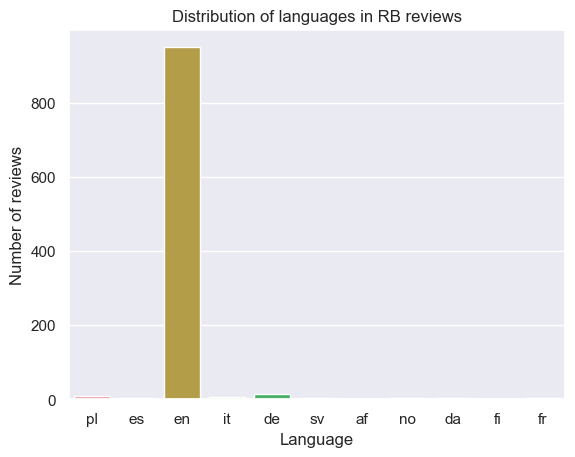

In [49]:
# display the distribution of languages
sns.set_theme(style="darkgrid")
ax = sns.countplot(x=RB_languages)
ax.set_title('Distribution of languages in RB reviews')
ax.set_xlabel('Language')
ax.set_ylabel('Number of reviews')
plt.show()

In [50]:
# find other language indexes
RB_languages.index('fi'), RB_languages.index('fr')

(683, 824)

In [51]:
# display other language reviews
print(RB_text[RB_languages.index('fi')], '\n') 
print(RB_text[RB_languages.index('fr')], '\n') 

 Hieman kevyt kaiken kaikkiaan. Tuoksu suht hento. Kevyt suklaa ja paahto. Maku perinteinen stout mutta melko vetinen. Väri todella tumma. 

 Ambrée sombre, petite carbo, petit collet persistant. Aromes de fruits rouges, passion.Mince, resineuse et sèche sur la finale. 



In [52]:
# display all languages but english
RB_languages_without_en = [lang for lang in RB_languages if lang != 'en']

c:\Users\fulci\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\fulci\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\fulci\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
c:\Users\fulci\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_d

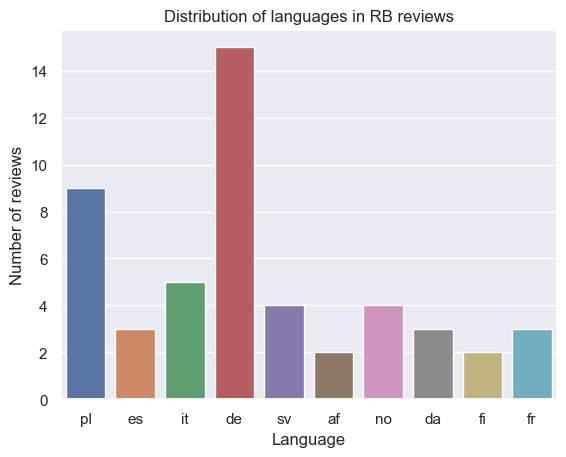

In [53]:
# display the distribution of languages without english
sns.set_theme(style="darkgrid")
ax = sns.countplot(x=RB_languages_without_en)
ax.set_title('Distribution of languages in RB reviews')
ax.set_xlabel('Language')
ax.set_ylabel('Number of reviews')
plt.show()

## Glutenfree beers vocabulary analysis

In [126]:
rb_gf_ratings=pd.read_csv(os.path.join(DATA_RateBeer, 'rb_gf_ratings.csv'), low_memory=False, encoding='utf-8')
print("# of samples: ", len(rb_gf_ratings))
print(rb_gf_ratings.columns)
rb_gf_ratings.head()

# of samples:  0
Index(['beer_name', 'beer_id', 'brewery_name', 'brewery_id', 'style', 'abv',
       'date', 'user_name', 'appearance', 'aroma', 'palate', 'taste',
       'overall', 'rating', 'text', 'user_id', 'location', 'year'],
      dtype='object')


,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,appearance,aroma,palate,taste,overall,rating,text,user_id,location,year


In [ ]:
# testing of the text format, can skip
for i in range(20, 190):
    display(rb_gf_ratings['text'][i])

## Temporal analysis of glutenfree beers

We first counts the number of reviews per year for gluten free beers.

In [ ]:
# plot the number of ratings per year
# create a Counter
number_rating=Counter(glutenfree['year'])
# sort by year
number_rating_srt=sorted(number_rating.items(), key=lambda pair: pair[0])

In [ ]:
# make a list of ('year', 'number of ratings') tuples
plt.figure(figsize=(10,5))
plt.bar([x[0] for x in number_rating_srt], [x[1] for x in number_rating_srt])
plt.xlabel('Year')
plt.ylabel('Number of ratings')
plt.title('Temporal analysis of glutenfree beers worldwide')

It showed that the ammount of reviews for gluten-free beers is increasing is the evolution of the popularity of the site? Is it because of the increase of total number of reviews in the dataset?

In [ ]:
#we take all the dates of the ratings, we transform them into 'readable' dates. 
#So that, we can count how many ratings by year, we have.
RB_ratings = pd.read_csv(os.path.join(DATA_RateBeer, 'RB_ratings.csv'))

In [ ]:
RB_ratings['date'].head()
# format 2016-04-26 10:00:00
# get the year 
RB_year = RB_ratings['date'].str.split('-').str[0]
# make it into int
RB_year = RB_year.astype(int)
RB_year.head()


In [ ]:
# generate a Counter object
RB_year_count = Counter(RB_year)
# order the Counter object by year
RB_year_count_srt = sorted(RB_year_count.items(), key=lambda pair: pair[0])
RB_year_count_srt

In [ ]:
# plot the number of ratings per year
plt.figure(figsize=(10,5))
plt.bar([pair[0] for pair in RB_year_count_srt], [pair[1] for pair in RB_year_count_srt])
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('All beers number of ratings per year')
plt.show()

In [ ]:
# get the proportion of glutenfree beers reviews, match the year
gluten_free_proportion = []
for year, count in number_rating_srt:
    if year in RB_year_count.keys():
        gluten_free_proportion.append((year, count/RB_year_count[year]))

gluten_free_proportion


In [ ]:
plt.figure(figsize=(10,5))
# plot the proportion of glutenfree beers reviews
plt.bar([pair[0] for pair in gluten_free_proportion], [pair[1] for pair in gluten_free_proportion])
plt.title('Evolution of the proportion of ratings on glutenfree beers')

It shows that the increase of gluten-free beers reviews is not due to the increase of the total number of reviews in the dataset.

Next we will look at the yearly statistics of some of the metrics.

In [ ]:
year_mean=glutenfree[['rating','year', 'appearance','aroma','palate','taste','overall']].groupby('year').mean()
year_std=glutenfree[['rating','year', 'appearance','aroma','palate','taste','overall']].groupby('year').std()
year_sem=glutenfree[['rating','year', 'appearance','aroma','palate','taste','overall']].groupby('year').sem()
year_mean

In [ ]:
#We choose to keep only data after 2010, because before 2010, we have not enough data to do statistics
after_2010_mean=year_mean[year_mean.index>=2010]
after_2010_std=year_std[year_std.index>=2010]
after_2010_sem=year_sem[year_sem.index>=2010]


In [ ]:
for item in after_2010_mean.columns:
    plt.plot(after_2010_mean.index, after_2010_mean[item])
    plt.fill_between(after_2010_mean.index, after_2010_mean[item] - 1.96 * after_2010_sem[item], 
                         after_2010_mean[item] + 1.96 *after_2010_sem[item], alpha=0.25
                         , color="tab:blue")
    plt.title(item)
    plt.show()

## Evolution of the number of ratings of glutenfree beers in function of the location

In [ ]:
#we group united states and europeans countries together
united_states=glutenfree[glutenfree['location'].str.contains('United States',case=False, na=False)]
european_countries = ['France', 'Germany', 'Italy', 'Spain', 'United Kingdom', 'Sweden', 'Norway', 'Denmark']

europe= glutenfree[glutenfree['location'].isin(european_countries)]

canada=glutenfree[glutenfree['location']=="Canada"]


In [ ]:
uni=united_states.groupby('year')['beer_name'].count()
eur=europe.groupby('year')['beer_name'].count()
can=canada.groupby('year')['beer_name'].count()

In [ ]:
plt.bar(uni.index, uni,label='United States')
plt.title('Number of ratings per year in the United States')

In [ ]:
plt.bar(eur.index, eur)
plt.title('Number of ratings per year in Europe')

In [ ]:
plt.bar(can.index, can)
plt.title('Number of ratings per year in Canada')

## Elementary analysis on vocabulary employed to describe glutenfree beers

After temporal EDA, the next step is to briefly analyze the vocabulary used to describe gluten-free beers. The capability to investigate vocabulary frequency would allow us to understand if there are some specific words that are used to describe gluten-free beers.

In [ ]:
text=glutenfree.groupby('year')['text'].sum()
text

In [ ]:
# Load the English language model
nlp = spacy.load('en_core_web_sm')

In [ ]:
for i in range(2006,2017):
    data=text.get(i, '')
    doc = nlp(data)
    
    cleaned_tokens = [token.text.strip() for token in doc if not (token.is_stop or token.is_punct or token.text.isspace())]
    word_freq = Counter(cleaned_tokens)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'year = {i}')
    plt.axis("off")
    plt.show()

We have to do deeper analysis for the P3: the next step is to keep only adjectives, that are more meaningful, and then do further ananlysis based on these adajectives.

In [ ]:
data=text.get(2006, '')
doc = nlp(data)
    
#We clean tokens
cleaned_tokens = [token.text.strip() for token in doc if not (token.is_stop or token.is_punct or token.text.isspace())]
word_freq = Counter(cleaned_tokens)
dim=len(cleaned_tokens)
#keep only tokens that appear more than 2 times
subset = {key: counter for key, counter in word_freq.items() if counter >= 2}
word=pd.DataFrame([subset])/dim

#do this for all the years and concatenate informations into 'word'
for i in range(2007,2017):
    data=text.get(i, '')
    doc = nlp(data)
        
    cleaned_tokens = [token.text.strip() for token in doc if not (token.is_stop or token.is_punct or token.text.isspace())]
    word_freq = Counter(cleaned_tokens)
    dim=len(cleaned_tokens)
    subset = {key: counter for key, counter in word_freq.items() if counter >= 2}
    w=pd.DataFrame([subset])/dim
    word = pd.concat([word, w], ignore_index=True)
    
word

The rows represents years from 2006, and for each words that often appear, we report its frequency yearly.

In [ ]:
each_year=word.T
each_year['na']=each_year.isna().sum(axis=1)
each_year['na']

In [ ]:
# to do a temporal analysis, we keep only words that appear during several years
interest=each_year[each_year['na']<3]
interest

In [ ]:
#We aim to analyze whether certain words exhibit significant variability in their frequency of appearance.
interest['std']=interest.std(axis=1)
wanted=interest[interest['std']>0.6]
wanted.sort_values(by='std', ascending=False)
wanted.T

In [ ]:
#look at this words
wanted.T.columns

In [ ]:
#plot the evolutions of the frequencies of appearance of some interesting words
wanted.T['strange'].iloc[:11].plot(kind='bar')

In [ ]:
wanted.T['Sweet'].iloc[:11].plot(kind='bar')

In [ ]:
wanted.T['bad'].iloc[:11].plot(kind='bar')

The analysis, we conduct, is just an introduction to see what we could do to identify 'BOBO'. We would proceed the "Fanciness analysis" for the next milestone.

## Diversity of beer style 

In [ ]:

beers=pd.read_csv(os.path.join(DATA_RateBeer, 'beers.csv'))
breweries=pd.read_csv(os.path.join(DATA_RateBeer, 'breweries.csv'))

In [ ]:
glutenfree_style=glutenfree.groupby('style')['beer_name'].count()
glutenfree_style.plot(kind='bar')

In [ ]:
glutenfree_style

In [ ]:
total_style=beers.groupby('style')['beer_name'].count()
nb_style_beer=len(total_style)

In [ ]:
print(f'It exists {len(glutenfree_style)} different styles of beer among gluten-free beers.')
print(f'In the entire dataset, we count {nb_style_beer} different styles of beer.')

In [ ]:
print(f'percentage of gluten_free beers : {len(glutenfree.index)/len(beers.index)*100}')

## Does glutenfree beers are more appreciated than other beers?
We will keep users that evaluated a similar number of glutenfree beer and non glutenfree beers to compare the grades between glutenfree and non glutenfree_beer


In [ ]:
# get user id from the glutenfree dataset
users = pd.read_csv(os.path.join(DATA_RateBeer, 'users.csv'))
user_id = RB_ratings['user_id']
user_id.head()

In [ ]:
nb_ratings=glutenfree.groupby('user_id')['user_name'].count()
nb_ratings=pd.DataFrame(nb_ratings)
nb_ratings.rename(columns={'user_name':'nb_ratings_glutenfree'}, inplace=True)
nb_ratings

In [ ]:
users_ratings=users[['nbr_ratings', 'user_id']]
users_ratings.set_index('user_id', inplace=True)
users_ratings

In [ ]:
gluten_users=pd.merge(users_ratings,nb_ratings, how='right', on='user_id')
gluten_users

In [ ]:
#We keep only users that have rated  a similar number of conentional beer and glutenfree beers
keep=gluten_users[(gluten_users['nbr_ratings']<=3*gluten_users['nb_ratings_glutenfree'])& (gluten_users['nbr_ratings']>gluten_users['nb_ratings_glutenfree'])]
print(keep['nbr_ratings'].sum())
print(keep['nb_ratings_glutenfree'].sum())

In [ ]:
#Now, we will recover the corresponding ratings of these users
positions_gluten = np.where(np.isin(users_id, keep.index.to_numpy()))[0]


In [ ]:
positions_gluten[1:10]

In [ ]:
len(positions_gluten)

In [ ]:
#we calculate the numbers of lines in the rating.txt file on which we have the corresponding ratings
positions_gluten*=17
lines_to_keep_gluten=[]
for i in range(17):
    lines_to_keep_gluten+=[element + i for element in positions_gluten]
lines_to_keep_gluten.sort()
lines_to_keep_gluten[1:10]

In [ ]:
input_file_path = 'ratings.txt'
output_file_path = 'glutenfree_users.txt'
#We read these line and put it into a new file: glutenfree_users.txt
import linecache
with  open(output_file_path, 'w') as output_file:
    for line_number in lines_to_keep_gluten:
        line = linecache.getline(input_file_path, line_number)
        output_file.write(line)
# Close the output file
output_file.close()

In [ ]:
#from the text file, we have just created, we create a csv file with the corresponding ratings
import pandas as pd
columns_name = ['beer_name', 'beer_id', 'brewery_name', 'brewery_id',
                'style', 'abv', 'date', 'user_name', 'user_id', 'appearance',
                'aroma', 'palate', 'taste', 'overall', 'rating', 'text']

# Create an empty DataFrame with the specified column names
df = pd.DataFrame(columns=columns_name)

with open('glutenfree_users.txt', 'r') as file:
    data = {}
    for i, line in enumerate(file):
        if i % 17 == 0:
            # This is the last line of a group, so add the data to the DataFrame
            #df = pd.concat([df, pd.DataFrame(data)], ignore_index=True)
            df = df._append(data, ignore_index=True)
            data = {}
        else:
            #print(line)
            # Split the line at the first ':' and assign the values to the corresponding column
            key, value = line.strip().split(':', 1)
            data[columns_name[i % 17 - 1]] = value

In [ ]:
csv_file_path = 'glutenfree_users.csv'  
df.to_csv(csv_file_path, index=False) 

In [ ]:
users_glutenfree=pd.read_csv('glutenfree_users.csv')

Let's first analyse if glutenfree beers are more appreciated than beers with gluten

In [ ]:
# The dataframe contains conventional beers and glutenfree beers, so we have a colomn indicating if the beer is glutenfree or not
users_glutenfree['glutenfree']=users_glutenfree['beer_name'].str.contains('gluten', case=False, na=False)
users_glutenfree.dropna(inplace=True)  

In [ ]:
users_glutenfree['glutenfree']

In [ ]:
users_glutenfree['glutenfree'].sum()

In [ ]:
glutenfree=users_glutenfree[users_glutenfree['glutenfree']]
gluten=users_glutenfree[~users_glutenfree['glutenfree']]
gluten

In [ ]:
glu=gluten[['appearance','aroma','palate','taste', 'overall','rating']]
freeglu=glutenfree[['appearance','aroma','palate','taste', 'overall','rating']]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(len(glu.columns), figsize=(10,10))
fig.suptitle('Gluten/Glutenfree')

for i,column in enumerate(glu.columns):
    sns.histplot(glu[column].dropna(), stat='density', kde=True, color='blue', label='gluten', ax=axs[i])
    sns.histplot(freeglu[column].dropna(), stat='density', kde=True, color='green', label='glutenfree', ax=axs[i])
    #axs[i].set_title(column)
    axs[i].legend()
plt.subplots_adjust(wspace=0.5, hspace=0.5)

In [ ]:
from statsmodels.stats import diagnostic
# does the data come from a normal distrbution?
diagnostic.kstest_normal(glutenfree['aroma'].values, dist = 'norm')

In [ ]:
from scipy.stats import ttest_ind
ttest=pd.DataFrame(columns=['Topic','T_stat','P_value'])
for col in glu.columns:
    t_stat, p_value = ttest_ind(glu[col], freeglu[col])
    ttest.loc[len(ttest)]={'Topic':col,'T_stat':t_stat,'P_value':p_value}
ttest

Glutenfree beers seem to affect the taste!

In [ ]:
for col in glu.columns:
    sns.barplot(x="glutenfree", y=col, data=users_glutenfree, )
    plt.show()

The taste seems to be the most affected parameter (negative impact)

Since the data is not normally distributed, I propose to do mannwhitneyu test to complete the t-test

In [ ]:
from scipy.stats import mannwhitneyu

correlations=pd.DataFrame(columns=['topic','statistic','pvalue'])

for column in glu.columns:
    x = glu[column]
    y = freeglu[column]

    # Perform the Mann-Whitney U test
    statistic, p_value = mannwhitneyu(x, y)

    correlations.loc[len(correlations)] = {'topic': column, 'statistic': statistic, 'pvalue': p_value}

print(correlations)


There is significant difference between gluten and glutenfree beers in terms of taste!

In [ ]:
users_glutenfree['glutenfree']=users_glutenfree['glutenfree'].astype(int)

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
mod = smf.ols(formula='rating ~ appearance + aroma + palate+ taste + overall+C(glutenfree)', data=users_glutenfree)
np.random.seed(2)
res = mod.fit()
print(res.summary())

In [ ]:
mod = smf.ols(formula='rating ~ appearance + aroma + palate+ taste + overall', data=users_glutenfree)
np.random.seed(2)
res = mod.fit()
print(res.summary())

The aroma, palate, taste and overall are very correlated with the rating as expected!
By adding information about the presence or absence of gluten, we don't explain much more the outcome!

In [ ]:
mod = smf.ols(formula='taste ~ C(glutenfree)', data=users_glutenfree)
res = mod.fit()
print(res.summary())

In [ ]:
plt.scatter(users_glutenfree['glutenfree'],users_glutenfree['taste'])
b=res.params.values[0]
a=res.params.values[1]
x=np.linspace(0,1,30)
plt.plot(x, a*x+b)

In [ ]:
sns.boxplot(x="glutenfree", y="taste", data=users_glutenfree)

In [ ]:
norm=pd.DataFrame()
# how we standardize the countinuous variables

norm['appearance'] = (users_glutenfree['appearance'] - users_glutenfree['appearance'].mean())/users_glutenfree['appearance'].std()
norm['taste'] = (users_glutenfree['taste'] - users_glutenfree['taste'].mean())/users_glutenfree['taste'].std()
norm['palate'] = (users_glutenfree['palate'] - users_glutenfree['palate'].mean())/users_glutenfree['palate'].std()
norm['aroma'] = (users_glutenfree['aroma'] - users_glutenfree['aroma'].mean())/users_glutenfree['aroma'].std()
norm['overall'] = (users_glutenfree['overall'] - users_glutenfree['overall'].mean())/users_glutenfree['overall'].std()
norm['rating'] = (users_glutenfree['rating'] - users_glutenfree['rating'].mean())/users_glutenfree['rating'].std()
norm['glutenfree']=users_glutenfree['glutenfree']

In [ ]:
norm

In [ ]:
# logistic regression to predict if the beer is glutenfree given ratings

mod = smf.logit(formula='glutenfree~  appearance+ taste + palate + \
                        aroma + overall', data=norm)
res = mod.fit()
print(res.summary())

In [ ]:
mod = smf.logit(formula='glutenfree~ taste + aroma ', data=norm)
res = mod.fit()
print(res.summary())

Glutenfree beers seem to affect the aroma and the taste of the beer!

# Sentiment Analysis

## Subsetting the data

Reviews of the beers matter. Similar as the numerical ratings, sentiment analysis can be used to indicate the evaluation the reviewer gave to the beer. Such an analysis would be helpful for us to understand the data better and to see if the reviews are in line with the numerical ratings across different beer types, breweries, regions, etc.

Here as a pilot study, we will simply use a subset of from the `BA_ratings` to conduct the sentiment analysis. We want to first see if the sentiment analysis can be done in a reasonable time with promising results. If so, we will then further look for potentially better models and implementations. (as for instance for the glutenfree beers)

In [ ]:
# show number of unique breweries
print('number of unique beer in BA:', len(BA_ratings['beer_id'].unique()))
# get the brewery id that appears the most time
print('most common beer id in BA:', BA_ratings['beer_id'].value_counts().idxmax())

In [ ]:
# subset the data to only contain the most common brewery id
BA_ratings_most_com_brw = BA_ratings.loc[BA_ratings['beer_id'] == BA_ratings['beer_id'].value_counts().idxmax()]
print("# samples: ", len(BA_ratings_most_com_brw))
print("# unique beers: ", len(BA_ratings_most_com_brw['beer_id'].unique()))
BA_ratings_most_com_brw.head(5)

In [ ]:
BA_ratings_most_com_brw.dtypes

In [ ]:
# filter the data with review == false
BA_ratings_most_com_brw = BA_ratings_most_com_brw.loc[BA_ratings_most_com_brw['review'] == " True"]
print("# samples: ", len(BA_ratings_most_com_brw))

The pilot analysis would focus on the 3811 samples, all corresponds to the most reviewed "Founders Breakfast Stout" from Founders Brewing Company.

## EDA and Data preprocessing

In [ ]:
BA_ratings_most_com_brw['rating'].describe()

In [ ]:
# study the distribution of rating
plt.figure(figsize=(10, 5))
plt.hist(BA_ratings_most_com_brw['rating'], bins=20, color = 'blue')
plt.xlabel('Rating')
plt.ylabel('Count')
# set x ticks
plt.xticks(np.arange(1, 6, 1))
plt.title('Distribution of Ratings')
plt.show()

Seems like the beer is not popular for no reason. The average rating is 4.46, which is very high. Due to the fact that sentiment analysis works better with discrete values, we convert the 2-decimal ratings into discrete values from 1 to 3.

In [ ]:
# add discrete rating column
# 1: 1-4, 2: 4-4.5, 3: 4.5-5
BA_ratings_most_com_brw['rating_discrete'] = BA_ratings_most_com_brw['rating'].apply(lambda x: 1 if x <= 4 else (2 if x <= 4.5 else 3))

# count the number of each discrete rating
BA_ratings_most_com_brw['rating_discrete'].value_counts()

## Pretrain model analysis

The model is downloaded from huggingface website. There are many different models for different usage, language, and output format. Here we applied 2-way classification trained on english product reviews.

In [ ]:
# get the pretrained model from huggingface's transformers library
#MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
MODEL = f"juliensimon/reviews-sentiment-analysis"
#MODEL = f"lxyuan/distilbert-base-multilingual-cased-sentiments-student"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Define the polarity scorer for a given sentence.

In [ ]:
# run sentiment analysis over all ratings['text']
def polarity_scores(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'o1' : scores[0],
        'o2' : scores[1]
    }
    return scores_dict

In [ ]:
# iterate over all rows and run polarity_scores
res = {}
for i, row in tqdm(BA_ratings_most_com_brw.iterrows(), total=BA_ratings_most_com_brw.shape[0]):
    try:
        text = row['text']
        myid = i
        result = polarity_scores(text)
        #result = extract_sentiment_words_attention(text)
        res[myid] = result
    except RuntimeError:
        print(f'Broke for id {myid}') # model can't handle some texts (i.e. too long)

In [ ]:
results_df = pd.DataFrame(res).T
# add column 'class', if o1 > o2, then class = 0, else class = 1
results_df['class'] = results_df['o1'].apply(lambda x: 0 if x > 0.5 else 1)
results_df.head()

In [ ]:
# merge the results with the original ratings dataframe
BA_ratings_most_com_brw_sentiment = BA_ratings_most_com_brw.merge(results_df, left_index=True, right_index=True)
BA_ratings_most_com_brw_sentiment.head()

To show how good the sentiment evaluation is, we correlate the positiveness/negativeness results with the ratings.

In [ ]:
sns.pairplot(data = BA_ratings_most_com_brw_sentiment,
             vars = ['o1', 'o2'],
             hue = 'rating_discrete',
             palette = 'tab10')
plt.show()

It seems that those comments with higher discrete ratings have generally better positivity, and vice versa. The preliminary analysis shows it is feasible to do sentiment analysis for the beer dataset. A possibly fine-grained version analysis would be carrying out.

That is pretty much what we have for milestone 2. As discussed in the readme file on Github, we will proceed our analysis according to our research questions.
Thank you for your time :]